# ICL evluation beased on LongBench

https://github.com/THUDM/LongBench

The LongBench is a dataset for long-context related tasks and the intuiation for choosing this STOA dataset is that:

Most of the models are trained for all the online available dataset and one thing need to be consider is that the newly released model has already trained on the dataset we used which can happen in most of the cases.

Long-context is still challanging for ICL but for short context, the model has already a high score and quality.

LongBench is a newly released dataset that can be eliminated from the training set for some of the models such as Llama 2.
In this study, this ICL tasks are implemented by the following steps:

1. Choose the two different dataset include TREC and TriviaQA which mainly focus on ICL tasks and then use differnet evaluation metrics such as CLS and F1 score.
2. Define the prompt for differnet models: Llama2, Llama3 etc.
   For example: 
    The prompt should be like the following in Llama2
   ```python   
   <s>[INST] <<SYS>>
   You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe. Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.

   <</SYS>>
   Please determine the type of the question below. Here are some examples of questions.
   Question: Why is Chicago named Chicago ?
   Type: Reason
   Question: What did Lenny Bruce say that got him arrested ?
   Type: Description of something
   Question: Who shot and killed himself while painting Wheatfield with Crows ?
   Type: Individual
   Question: How much would a black-and-white 1-cent stamp be worth , Thomas Jefferson on it ?
   Type: Price
   Question: How many points are there on a Backgammon board ?
   Type: Number of something
   Question: What is a dangling participle ?
   Type: Definition of something
   Question: Where do the adventures of `` The Swiss Family Robinson '' take place ?
   Type: Other location
   Question: Who was the first American world chess champion ?
   Type: Individual
   Question: What colorful sea 's region does Greek legend say the Amazons lived near ?
   Type: Other location
   Question: Where is Logan Airport ?
   Type: Other location
   Question: What is the highest Roman numeral ?
   Type: Definition of something
   Question: In what city is the famed St. Mark 's Square ?
   Type: City
   Question: Who was Damocles ?
   Type: Description of a person
   Question: What are some science fair projects for 8th graders ?
   Type: Event
   Question: Name a film in which Jude Law acted .
   Type: Invention, book and other creative piece
   Question: What 's the highest possible bid in Contract Bridge ?
   Type: Other entity
   Question: When did Amtrak begin operations ?
   Type: Date

   My Question: How many Admirals are there in the U.S. Navy ?
   Type:

   Respond exclusively with the specified type as demonstrated earlier. Irrelevant responses will not be tolerated. Type names only!
   [/INST]
   ```
1. Then get the response from models and calculate the score
2. Finally, do the statistical analysis and causal modeling for future usage.


In [1]:
import pandas as pd
import time
from openai import OpenAI
from tqdm import tqdm
import os

foler_path = "data/ICL"
file_name = "exp_result_Meta-Llama-3-70B-Instruct_20240531140350_951758.csv"
output_file_name = file_name.replace(".csv", "_evaluated.csv")
input_path = os.path.join(foler_path, file_name)
output_path = os.path.join(foler_path, output_file_name)
_data = pd.read_csv(input_path)
eval_model = "gpt-3.5-turbo-0125"
api_key = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=api_key)
temperature = 0

categories = [
    "Food",
    "Date",
    "Order, rank",
    "Speed",
    "Disease and medicine",
    "Word with a special property",
    "Abbreviation",
    "Language",
    "Letter like a-z",
    "Other entity",
    "Animal",
    "Expression abbreviated",
    "Price",
    "Techniques and method",
    "Musical instrument",
    "Mountain",
    "Currency name",
    "Event",
    "Product",
    "State",
    "Individual",
    "Organ of body",
    "Reason",
    "Manner of an action",
    "City",
    "Religion",
    "Invention, book and other creative piece",
    "Distance, linear measure",
    "Temperature",
    "Postcode or other code",
    "Size, area and volume",
    "Sport",
    "Country",
    "Other location",
    "Lasting time of somethin",
    "Equivalent term",
    "Description of something",
    "Weight",
    "Vehicle",
    "Color",
    "Other number",
    "Definition of something",
    "Element and substance",
    "Description of a person",
    "Symbols and sign",
    "Number of something",
    "Plant",
    "Percent, fraction",
    "Group or organization of person",
    "Title of a person",
]

In [2]:
def extract_final_response(response, prompt):
    return response[len(prompt) :]


def match_prompt_column(model):
    if "Llama-2" in model:
        return "llama2_chat_initial_prompt"
    elif "Mixtral" in model or "Mistral" in model:
        return "mixtral_instruct_initial_prompt"
    elif "Llama-3" in model:
        return "llama3_chat_initial_prompt"
    else:
        print("The model name didn't match anything, please check!!!!")
        return None


def extract_pure_response(row):
    model = row["model"]
    prompt_column = match_prompt_column(model)
    response = row["generated_response"]
    prompt = row[prompt_column]
    return extract_final_response(response=response, prompt=prompt)


def process_string(input_string):
    processed_string = input_string.strip("[]").replace("\\", "")
    questions = processed_string.split("\n")
    questions = [q.strip("'") for q in questions]
    return questions


_data["pure_response"] = _data.apply(extract_pure_response, axis=1)

In [3]:
import re
import string
from collections import Counter


def classification_score(prediction, ground_truth, all_classes):
    em_match_list = []
    for class_name in all_classes:
        if class_name in prediction:
            em_match_list.append(class_name)
    for match_term in em_match_list:
        if match_term in ground_truth and match_term != ground_truth:
            em_match_list.remove(match_term)
    if ground_truth in em_match_list:
        score = 1.0 / len(em_match_list)
    else:
        score = 0.0
    return score


def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""

    def remove_articles(text):
        return re.sub(r"\b(a|an|the)\b", " ", text)

    def white_space_fix(text):
        return " ".join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))


def f1_score(prediction, ground_truth, **kwargs):
    common = Counter(prediction) & Counter(ground_truth)
    num_same = sum(common.values())
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(prediction)
    recall = 1.0 * num_same / len(ground_truth)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1


def qa_f1_score(prediction, ground_truth):
    normalized_prediction = normalize_answer(prediction)
    normalized_ground_truth = normalize_answer(ground_truth)

    prediction_tokens = normalized_prediction.split()
    ground_truth_tokens = normalized_ground_truth.split()
    return f1_score(prediction_tokens, ground_truth_tokens)


def calculate_classification_score(row, all_classes):
    prediction = row["pure_response"]
    answer = row["answers"].strip("[]' ")
    score = classification_score(prediction, answer, all_classes)
    return score


def calculate_qa_f1_score(row):
    prediction = row["pure_response"]
    answer = row["answers"]
    score = qa_f1_score(prediction=prediction, ground_truth=answer)
    return score

In [4]:
trec_dataset = _data[_data["dataset_name"] == "trec"]
triviaqa = _data[_data["dataset_name"] == "triviaqa"]

trec_dataset["classification_score"] = trec_dataset.apply(
    calculate_classification_score, args=(categories,), axis=1
)

triviaqa["qa_f1_score"] = triviaqa.apply(calculate_qa_f1_score, axis=1)
merged_dataset = pd.concat([trec_dataset, triviaqa])

/tmp/ipykernel_1925454/156266619.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trec_dataset["classification_score"] = trec_dataset.apply(
/tmp/ipykernel_1925454/156266619.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  triviaqa["qa_f1_score"] = triviaqa.apply(calculate_qa_f1_score, axis=1)


In [ ]:
import matplotlib.pyplot as plt

grouped_data = trec_dataset.groupby("Temperature")["classification_score"].mean()
grouped_data.plot(kind="bar")
plt.xlabel("Temperature")
plt.ylabel("Mean Classification Score")
plt.title("Mean Classification Score Grouped by Temperature")
plt.show()

# Analysis Integrated

In [1]:
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt

current_time = datetime.datetime.now()
current_time_str = current_time.strftime("%Y%m%d%H%M%S")
model_weight_sizes = {
    "Llama-2-13b-chat-hf": 13,
    "Mistral-7B-Instruct-v0.2": 7,
    "Llama-2-70b-chat-hf": 70,
    "Meta-Llama-3-8B-Instruct": 8,
    "Llama-2-7b-chat-hf": 7,
    "Mixtral-8x7B-Instruct-v0.1": 56,
}

folder_path = "data/ICL"
output_photo_name = f"ICL_{current_time_str}.svg"
output_photo_path = os.path.join(folder_path, output_photo_name)
all_dfs = []
for filename in os.listdir(folder_path):
    if filename.endswith(".csv") and "evaluated" in filename:
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        model_name = filename.split("_")[2]
        df["model_name"] = model_name
        df["weight_size"] = model_weight_sizes.get(model_name, None)
        all_dfs.append(df)

df = pd.concat(all_dfs, ignore_index=True)

Triviaqa results visualization

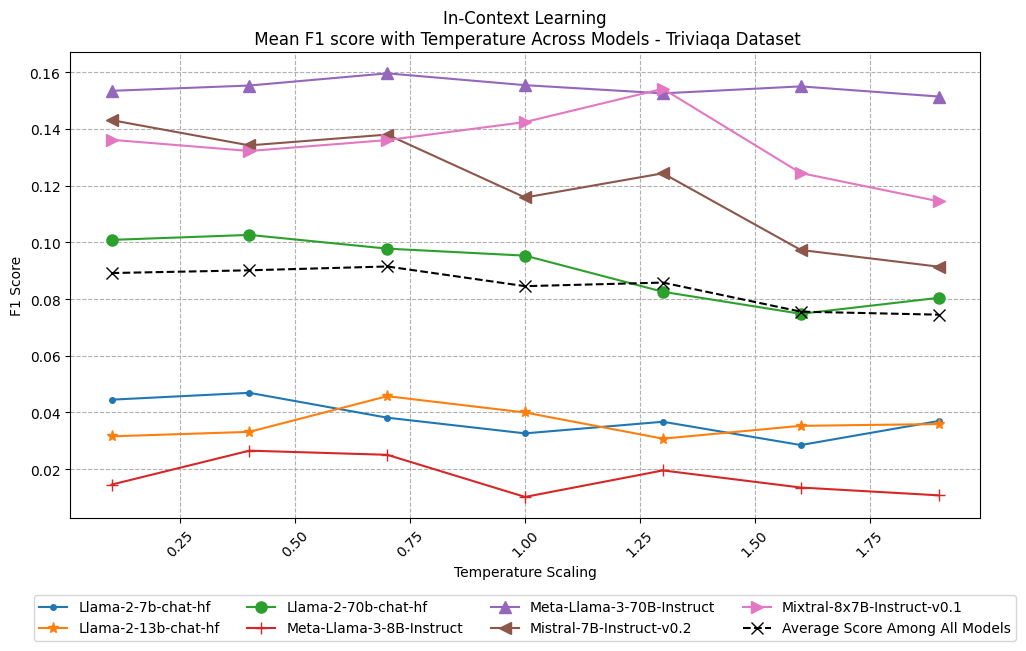

In [2]:
df1 = df[df["dataset_name"] == "triviaqa"]
grouped_data = df1.groupby(["model", "Temperature"])["qa_f1_score"].mean()

models = [
    "Llama-2-7b-chat-hf",
    "Llama-2-13b-chat-hf",
    "Llama-2-70b-chat-hf",
    "Meta-Llama-3-8B-Instruct",
    "Meta-Llama-3-70B-Instruct",
    "Mistral-7B-Instruct-v0.2",
    "Mixtral-8x7B-Instruct-v0.1",
]

markers = [
    ".",
    "*",
    "o",
    "+",
    "^",
    "<",
    ">",
    "8",
    "s",
    "p",
    ",",
    "v",
    "D",
    "d",
    "x",
    "|",
    "_",
]

plt.figure(figsize=(10, 6))
for i, model in enumerate(models):
    model_data = grouped_data[model]
    marker = markers[i % len(markers)]  # Select marker cyclically from the list
    plt.plot(
        model_data.index.get_level_values("Temperature"),
        model_data,
        marker=marker,
        markersize=8,
        label=model,
    )

grouped_data_temperature = df.groupby(["Temperature"])["qa_f1_score"].mean()
plt.plot(
    grouped_data_temperature.index,
    grouped_data_temperature,
    linestyle="--",
    marker="x",
    markersize=8,
    color="black",
    label="Average Score Among All Models",
)

plt.xlabel("Temperature Scaling")
plt.ylabel("F1 Score")
plt.title(
    "In-Context Learning\n Mean F1 score with Temperature Across Models - Triviaqa Dataset"
)
plt.grid(
    linestyle="--",
)
plt.xticks(rotation=45)
plt.tight_layout()

plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.savefig(output_photo_path, format="svg", bbox_inches="tight")
plt.show()

trec visualization

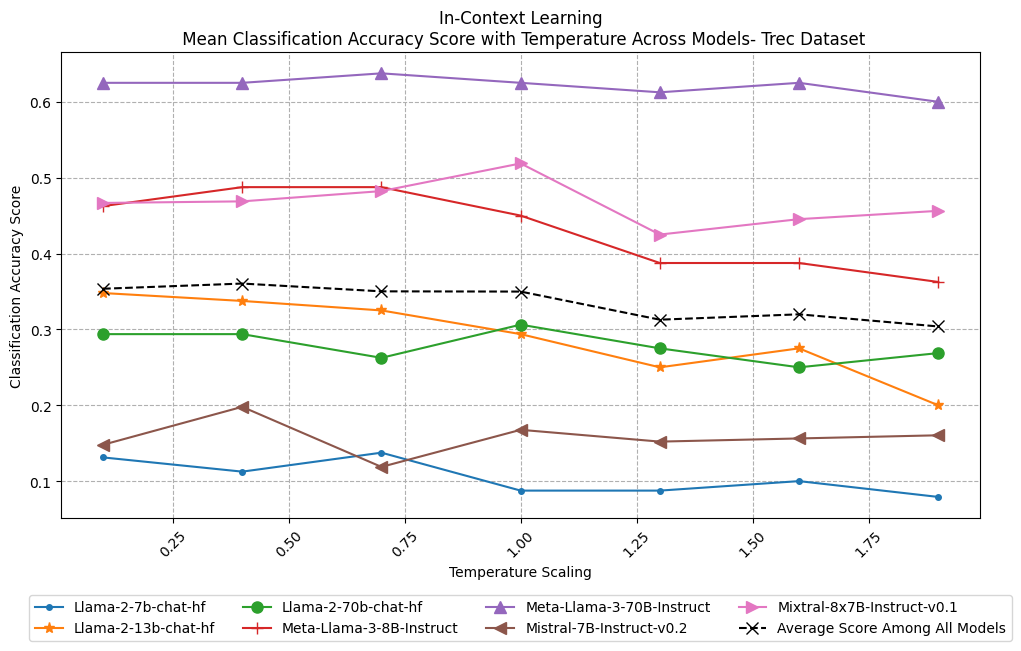

In [4]:
df2 = df[df["dataset_name"] == "trec"]
grouped_data = df2.groupby(["model", "Temperature"])["classification_score"].mean()

models = [
    "Llama-2-7b-chat-hf",
    "Llama-2-13b-chat-hf",
    "Llama-2-70b-chat-hf",
    "Meta-Llama-3-8B-Instruct",
    "Meta-Llama-3-70B-Instruct",
    "Mistral-7B-Instruct-v0.2",
    "Mixtral-8x7B-Instruct-v0.1",
]

markers = [
    ".",
    "*",
    "o",
    "+",
    "^",
    "<",
    ">",
    "8",
    "s",
    "p",
    ",",
    "v",
    "D",
    "d",
    "x",
    "|",
    "_",
]

plt.figure(figsize=(10, 6))
for i, model in enumerate(models):
    model_data = grouped_data[model]
    marker = markers[i % len(markers)]  # Select marker cyclically from the list
    plt.plot(
        model_data.index.get_level_values("Temperature"),
        model_data,
        marker=marker,
        markersize=8,
        label=model,
    )

grouped_data_temperature = df.groupby(["Temperature"])["classification_score"].mean()
plt.plot(
    grouped_data_temperature.index,
    grouped_data_temperature,
    linestyle="--",
    marker="x",
    markersize=8,
    color="black",
    label="Average Score Among All Models",
)

plt.xlabel("Temperature Scaling")
plt.ylabel("Classification Accuracy Score")
plt.title(
    "In-Context Learning\n Mean Classification Accuracy Score with Temperature Across Models- Trec Dataset"
)
plt.grid(
    linestyle="--",
)
plt.xticks(rotation=45)
plt.tight_layout()

plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.savefig(output_photo_path, format="svg", bbox_inches="tight")
plt.show()

Put two datasets' result together

In [4]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler()
df["qa_f1_score_normalized"] = scaler.fit_transform(df[["qa_f1_score"]])
df["classification_score_normalized"] = scaler.fit_transform(
    df[["classification_score"]]
)
df["composite_score"] = np.where(
    df["qa_f1_score"].notnull(), df["qa_f1_score"], df["classification_score"]
)

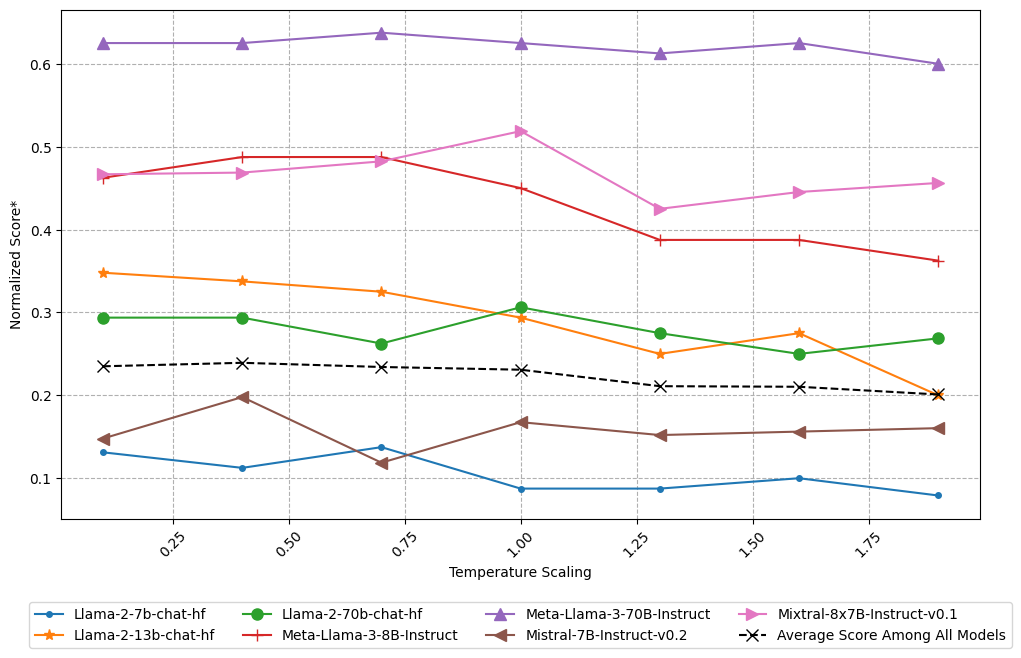

In [5]:
df2 = df[df["dataset_name"] == "trec"]
grouped_data = df2.groupby(["model", "Temperature"])["composite_score"].mean()

models = [
    "Llama-2-7b-chat-hf",
    "Llama-2-13b-chat-hf",
    "Llama-2-70b-chat-hf",
    "Meta-Llama-3-8B-Instruct",
    "Meta-Llama-3-70B-Instruct",
    "Mistral-7B-Instruct-v0.2",
    "Mixtral-8x7B-Instruct-v0.1",
]

markers = [
    ".",
    "*",
    "o",
    "+",
    "^",
    "<",
    ">",
    "8",
    "s",
    "p",
    ",",
    "v",
    "D",
    "d",
    "x",
    "|",
    "_",
]

plt.figure(figsize=(10, 6))
for i, model in enumerate(models):
    model_data = grouped_data[model]
    marker = markers[i % len(markers)]  # Select marker cyclically from the list
    plt.plot(
        model_data.index.get_level_values("Temperature"),
        model_data,
        marker=marker,
        markersize=8,
        label=model,
    )

grouped_data_temperature = df.groupby(["Temperature"])["composite_score"].mean()
plt.plot(
    grouped_data_temperature.index,
    grouped_data_temperature,
    linestyle="--",
    marker="x",
    markersize=8,
    color="black",
    label="Average Score Among All Models",
)

plt.xlabel("Temperature Scaling")
plt.ylabel("Normalized Score*")
# plt.title("In-context Learning\n Mean Normalized Score with Temperature Across Models")
plt.grid(
    linestyle="--",
)
plt.xticks(rotation=45)
plt.tight_layout()

# plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.savefig(output_photo_path, format="svg", bbox_inches="tight")
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.show()

In [6]:
from scipy.stats import kendalltau
import statsmodels.api as sm
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import pandas as pd


metric_name = "composite_score"

models = [
    "Llama-2-7b-chat-hf",
    "Llama-2-13b-chat-hf",
    "Llama-2-70b-chat-hf",
    "Meta-Llama-3-8B-Instruct",
    "Meta-Llama-3-70B-Instruct",
    "Mistral-7B-Instruct-v0.2",
    "Mixtral-8x7B-Instruct-v0.1",
]

results = []
# Calculate the results for all the models
for model_name in models:
    model_data = df[df["model"] == model_name]
    temperatures = model_data["Temperature"].values
    # Normalised Accuracy Value So That The Accuracy Can Be comparable
    accuracy = model_data[metric_name].values
    accuracy = (accuracy - np.min(accuracy)) / (np.max(accuracy) - np.min(accuracy))
    # Calculate Correlation Metrics
    corr, p_value = spearmanr(temperatures, accuracy)
    temperatures = sm.add_constant(temperatures)
    model = sm.OLS(accuracy, temperatures).fit()
    predictions = model.predict(temperatures)
    se = np.sqrt(mean_squared_error(accuracy, predictions))
    r_squared = model.rsquared
    r_squared_adj = model.rsquared_adj
    beta_hat = model.params
    results.append(
        {
            "model": model_name,
            "beta+-SE": f"{beta_hat[1]:.3f} ± {se:.3f}",
            "r_squared": f"{r_squared:.3f}",
            "r_squared_adj": f"{r_squared_adj:.3f}",
            "Spearman correlation Coefficient": f"{corr:.3f}",
            "P_value": f"{p_value:.3f}",
            "se": f"{se:.3f}",
            "beta_hat_0": f"{beta_hat[0]:.3f}",
            "beta_hat_1": f"{beta_hat[1]:.3f}",
        }
    )


# The Calcluation for all the results accross the model
model_data = df
temperatures = model_data["Temperature"].values
accuracy = model_data[metric_name].values
accuracy = (accuracy - np.min(accuracy)) / (np.max(accuracy) - np.min(accuracy))
corr, p_value = spearmanr(temperatures, accuracy)
temperatures = sm.add_constant(temperatures)
model = sm.OLS(accuracy, temperatures).fit()
predictions = model.predict(temperatures)
se = np.sqrt(mean_squared_error(accuracy, predictions))
r_squared = model.rsquared
r_squared_adj = model.rsquared_adj
beta_hat = model.params
results.append(
    {
        "model": "All",
        "beta+-SE": f"{beta_hat[1]:.3f} ± {se:.3f}",
        "r_squared": f"{r_squared:.3f}",
        "r_squared_adj": f"{r_squared_adj:.3f}",
        "Spearman correlation Coefficient": f"{corr:.3f}",
        "P_value": f"{p_value:.3f}",
        "se": f"{se:.3f}",
        "beta_hat_0": f"{beta_hat[0]:.3f}",
        "beta_hat_1": f"{beta_hat[1]:.3f}",
    }
)


grouped_data = df.groupby(["Temperature"])[metric_name].mean().reset_index()

average_performance = grouped_data[metric_name].mean()

standard_deviation = grouped_data[metric_name].std()

range_value = grouped_data[metric_name].max() - grouped_data[metric_name].min()
statistical_range_percentage = (range_value / average_performance) * 100

coefficient_of_variation = (standard_deviation / average_performance) * 100

average_performance, standard_deviation, statistical_range_percentage, coefficient_of_variation

results_df = pd.DataFrame(results)
results_df

filtered_row = results_df[results_df["model"] == "All"]
spearman_coefficient = float(filtered_row["Spearman correlation Coefficient"].values[0])
p_value = float(filtered_row["P_value"].values[0])

print(f"Average Performance: {average_performance:.3f}")
print(f"Spearman correlation Coefficient: {spearman_coefficient:.3f}")
print(f"p_value: {p_value:.3f}")
# print(f"Standard Deviation: {standard_deviation:.3f}")
print(f"Range Percentage: {statistical_range_percentage:.3f}%")
print(f"Coefficient of Variation: {coefficient_of_variation:.3f}")

KeyError: 'Normalized Score'

In [9]:
from scipy.stats import kendalltau
import statsmodels.api as sm
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
from scipy.stats import pearsonr

models = [
    "Llama-2-7b-chat-hf",
    "Llama-2-13b-chat-hf",
    "Llama-2-70b-chat-hf",
    "Meta-Llama-3-8B-Instruct",
    "Meta-Llama-3-70B-Instruct",
    "Mistral-7B-Instruct-v0.2",
    "Mixtral-8x7B-Instruct-v0.1",
]

results = []
for model_name in models:
    model_data = df[df["model"] == model_name]
    temperatures = model_data["Temperature"].values
    accuracy = model_data["composite_score"].values
    corr, p_value = spearmanr(temperatures, accuracy)
    temperatures = sm.add_constant(temperatures)
    model = sm.OLS(accuracy, temperatures).fit()
    predictions = model.predict(temperatures)
    se = np.sqrt(mean_squared_error(accuracy, predictions))
    r_squared = model.rsquared
    r_squared_adj = model.rsquared_adj
    beta_hat = model.params
    results.append(
        {
            "model": model_name,
            "beta+-SE": f"{beta_hat[1]:.3f} ± {se:.3f}",
            "r_squared": f"{r_squared:.3f}",
            "r_squared_adj": f"{r_squared_adj:.3f}",
            "Spearman correlation Coefficient": f"{corr:.3f}",
            "P_value": f"{p_value:.3f}",
            "se": f"{se:.3f}",
            "beta_hat_0": f"{beta_hat[0]:.3f}",
            "beta_hat_1": f"{beta_hat[1]:.3f}",
        }
    )


results_df = pd.DataFrame(results)
results_df.to_csv("output.csv")